# Optimization using Genetic Algorithm 

## 0. Import necessary Libraries

In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import stellargraph as sg
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import sys

## 1. Load the data 

In [3]:
# Load the data
shapefile_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zones\taxi_zones\taxi_zones.shp"
zone_info_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zone_lookup.csv"
demand_data_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\taxi_data_cols.csv"

taxi_zones = gpd.read_file(shapefile_path)
zone_info = pd.read_csv(zone_info_path)
demand_data = pd.read_csv(demand_data_path)

In [4]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...  


In [5]:
print(zone_info.head())

   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone


In [6]:
print(demand_data.head())

   PULocationID  DOLocationID      pickup_datetime  trip_distance
0            42            42  2022-01-01 00:14:21           0.44
1           116            41  2022-01-01 00:20:55           2.10
2            41           140  2022-01-01 00:57:02           3.70
3           181           181  2022-01-01 00:07:42           1.69
4            33           170  2022-01-01 00:07:50           6.26


In [7]:
# Process the data
taxi_zones = taxi_zones.drop(columns=['LocationID'])
taxi_zones = taxi_zones.merge(zone_info, left_on="OBJECTID", right_on="LocationID")

In [8]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone        borough  \
0         1    0.116357    0.000782           Newark Airport            EWR   
1         2    0.433470    0.004866              Jamaica Bay         Queens   
2         3    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3         4    0.043567    0.000112            Alphabet City      Manhattan   
4         5    0.092146    0.000498            Arden Heights  Staten Island   

                                            geometry  LocationID  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...           1   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...           2   
2  POLYGON ((1026308.770 256767.698, 1026495.593 ...           3   
3  POLYGON ((992073.467 203714.076, 992068.667 20...           4   
4  POLYGON ((935843.310 144283.336, 936046.565 14...           5   

         Borough                     Zone service_zone  
0            EWR           Newark Airport          EWR  
1 

## 2. Process Data + Create Graph

In [9]:
# Filter to match unique zones in demand data
unique_zones_filtered = set(taxi_zones["LocationID"].unique()) - {103, 104, 110}
taxi_zones_filtered = taxi_zones[taxi_zones['OBJECTID'].isin(unique_zones_filtered)]

In [10]:
# Extract coordinates
taxi_zones_filtered['centroid'] = taxi_zones_filtered.centroid
taxi_zones_filtered['centroid_x'] = taxi_zones_filtered.centroid.x
taxi_zones_filtered['centroid_y'] = taxi_zones_filtered.centroid.y

coords = taxi_zones_filtered[['LocationID', 'centroid_x', 'centroid_y']]
coords_gdf = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords.centroid_x, coords.centroid_y))
coords_gdf.set_crs(epsg=2263, inplace=True)
coords_gdf = coords_gdf.to_crs(epsg=4326)

coords_gdf['centroid_lat'] = np.radians(coords_gdf.geometry.y)
coords_gdf['centroid_lon'] = np.radians(coords_gdf.geometry.x)

C:\Users\Paula\myenv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Paula\myenv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Paula\myenv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [11]:
print(coords_gdf.head())

   LocationID    centroid_x     centroid_y                    geometry  \
0           1  9.359968e+05  191376.749531  POINT (-74.17400 40.69183)   
1           2  1.031086e+06  164018.754403  POINT (-73.83130 40.61675)   
2           3  1.026453e+06  254265.478659  POINT (-73.84742 40.86447)   
3           4  9.906340e+05  202959.782391  POINT (-73.97697 40.72375)   
4           5  9.318714e+05  140681.351376  POINT (-74.18848 40.55266)   

   centroid_lat  centroid_lon  
0      0.710206     -1.294581  
1      0.708896     -1.288599  
2      0.713220     -1.288881  
3      0.710764     -1.291142  
4      0.707777     -1.294833  


In [12]:
# Create the graph
G = nx.Graph()
for _, row in coords.iterrows():
    G.add_node(row['LocationID'], pos=(row['centroid_x'], row['centroid_y']), features=[row['centroid_x'], row['centroid_y']])

coords_rad = coords_gdf[['centroid_lat', 'centroid_lon']].to_numpy()
distances = haversine_distances(coords_rad) * 6371000 / 1609.34  # Convert to miles

threshold_distance = 20  # Threshold in miles
for i, zone1 in enumerate(coords['LocationID']):
    for j, zone2 in enumerate(coords['LocationID']):
        if i != j and distances[i, j] < threshold_distance:
            G.add_edge(zone1, zone2, weight=distances[i, j])

node_features = pd.DataFrame.from_dict({node: data['features'] for node, data in G.nodes(data=True)}, orient='index')
stellar_graph = sg.StellarGraph.from_networkx(G, node_features=node_features)
adj_matrix = stellar_graph.to_adjacency_matrix()

In [13]:
merged_data = taxi_zones.merge(coords_gdf, on='LocationID')
print(merged_data.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone        borough  \
0         1    0.116357    0.000782           Newark Airport            EWR   
1         2    0.433470    0.004866              Jamaica Bay         Queens   
2         3    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3         4    0.043567    0.000112            Alphabet City      Manhattan   
4         5    0.092146    0.000498            Arden Heights  Staten Island   

                                          geometry_x  LocationID  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...           1   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...           2   
2  POLYGON ((1026308.770 256767.698, 1026495.593 ...           3   
3  POLYGON ((992073.467 203714.076, 992068.667 20...           4   
4  POLYGON ((935843.310 144283.336, 936046.565 14...           5   

         Borough                     Zone service_zone    centroid_x  \
0            EWR           Newark Airport   

## 3. Create GA to solve the VRP

In [28]:
def genetic_algorithm_vrp(data,zones, capacity, popsize, iterations, threshold_distance):

    selected_zones = data[data['zone'].isin(zones)]
    
    # Create vrp_nodes from the selected zones
    vrp_nodes = [{'label': row['zone'], 'demand': 1, 'posX': row['centroid_x'], 'posY': row['centroid_y']} for _, row in selected_zones.iterrows()]

    # Define necessary functions 
    def distance(n1, n2):
        dx = n2['posX'] - n1['posX']
        dy = n2['posY'] - n1['posY']
        return math.sqrt(dx * dx + dy * dy)

    def fitness(p):
        s = distance(vrp_nodes[0], vrp_nodes[p[0]])
        for i in range(len(p) - 1):
            prev = vrp_nodes[p[i]]
            next = vrp_nodes[p[i + 1]]
            s += distance(prev, next)
        s += distance(vrp_nodes[p[len(p) - 1]], vrp_nodes[0])
        return s

    def adjust(p):
        all_nodes = set(range(1, len(vrp_nodes)))  # All nodes except depot
        while True:
            unique_nodes = set(p)
            if len(unique_nodes) == len(p) and unique_nodes == all_nodes:
                break
            missing_nodes = all_nodes - unique_nodes
            for i in range(len(p)):
                if p.count(p[i]) > 1:
                    p[i] = missing_nodes.pop()
                    if not missing_nodes:
                        break
        i = 0
        s = 0.0
        cap = capacity
        while i < len(p):
            s += vrp_nodes[p[i]]['demand']
            if s > cap:
                p.insert(i, 0)
                s = 0.0
            i += 1
        i = len(p) - 2
        while i >= 0:
            if p[i] == 0 and p[i + 1] == 0:
                del p[i]
            i -= 1

    # Initialize population
    pop = []
    for i in range(popsize):
        p = list(range(1, len(vrp_nodes)))
        random.shuffle(p)
        pop.append(p)
    for p in pop:
        adjust(p)

    #  Main loop of the genetic algorithm
    for i in range(iterations):
        nextPop = []
        for j in range(int(len(pop) / 2)):
            parentIds = set()
            while len(parentIds) < 4:
                parentIds |= {random.randint(0, len(pop) - 1)}
            parentIds = list(parentIds)
            parent1 = pop[parentIds[0]] if fitness(pop[parentIds[0]]) < fitness(pop[parentIds[1]]) else pop[parentIds[1]]
            parent2 = pop[parentIds[2]] if fitness(pop[parentIds[2]]) < fitness(pop[parentIds[3]]) else pop[parentIds[3]]
            cutIdx1, cutIdx2 = random.randint(1, min(len(parent1), len(parent2)) - 1), random.randint(1, min(len(parent1), len(parent2)) - 1)
            cutIdx1, cutIdx2 = min(cutIdx1, cutIdx2), max(cutIdx1, cutIdx2)
            child1 = parent1[:cutIdx1] + parent2[cutIdx1:cutIdx2] + parent1[cutIdx2:]
            child2 = parent2[:cutIdx1] + parent1[cutIdx1:cutIdx2] + parent2[cutIdx2:]
            nextPop += [child1, child2]
        if random.randint(1, 15) == 1:
            ptomutate = nextPop[random.randint(0, len(nextPop) - 1)]
            i1 = random.randint(0, len(ptomutate) - 1)
            i2 = random.randint(0, len(ptomutate) - 1)
            ptomutate[i1], ptomutate[i2] = ptomutate[i2], ptomutate[i1]
        for p in nextPop:
            adjust(p)
        pop = nextPop

    # Select the best individual
    better = None
    bf = float('inf')
    for p in pop:
        f = fitness(p)
        if f < bf:
            bf = f
            better = p

    # Visualize the route
    route = [0] + better + [0]  # Incluir el depósito al inicio y al final
    plt.figure(figsize=(10, 10))
    df_vrp = pd.DataFrame(vrp_nodes)
    plt.scatter(df_vrp['posX'], df_vrp['posY'], c='blue', marker='o', label='Nodes')
    plt.scatter(df_vrp.iloc[0]['posX'], df_vrp.iloc[0]['posY'], c='red', marker='x', label='Depot')

    #  Draw lines between the nodes in the route and annotate the numbers on the lines
    for i in range(len(route) - 1):
        n1 = vrp_nodes[route[i]]
        n2 = vrp_nodes[route[i + 1]]
        plt.plot([n1['posX'], n2['posX']], [n1['posY'], n2['posY']], 'k-')
        plt.text((n1['posX'] + n2['posX']) / 2, (n1['posY'] + n2['posY']) / 2, str(i), fontsize=12, color='green')  # Anotar líneas con número de orden
        plt.text(n1['posX'], n1['posY'], n1['label'], fontsize=12, color='blue')  # Anotar nodos con nombres de zonas
    plt.text(vrp_nodes[route[-1]]['posX'], vrp_nodes[route[-1]]['posY'], vrp_nodes[route[-1]]['label'], fontsize=12, color='blue')  # Anotar el último nodo

    plt.title('Optimal Route with Order Numbers')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

    # Return the solution
    route_labels = ['depot'] + [vrp_nodes[nodeIdx]['label'] for nodeIdx in better] + ['depot']
    return route_labels, bf


## Some examples 

In [40]:
# Define the zones to use
zones1 = ['Newark Airport', 'Jamaica Bay','Alphabet City', 'Arden Heights','Woodlawn/Wakefield']
zones2=['Yorkville East', 'World Trade Center', 'Queens', 'Yorkville West']
all_zones = merged_data['zone'].unique()
random_zones = random.sample(list(all_zones), 5)

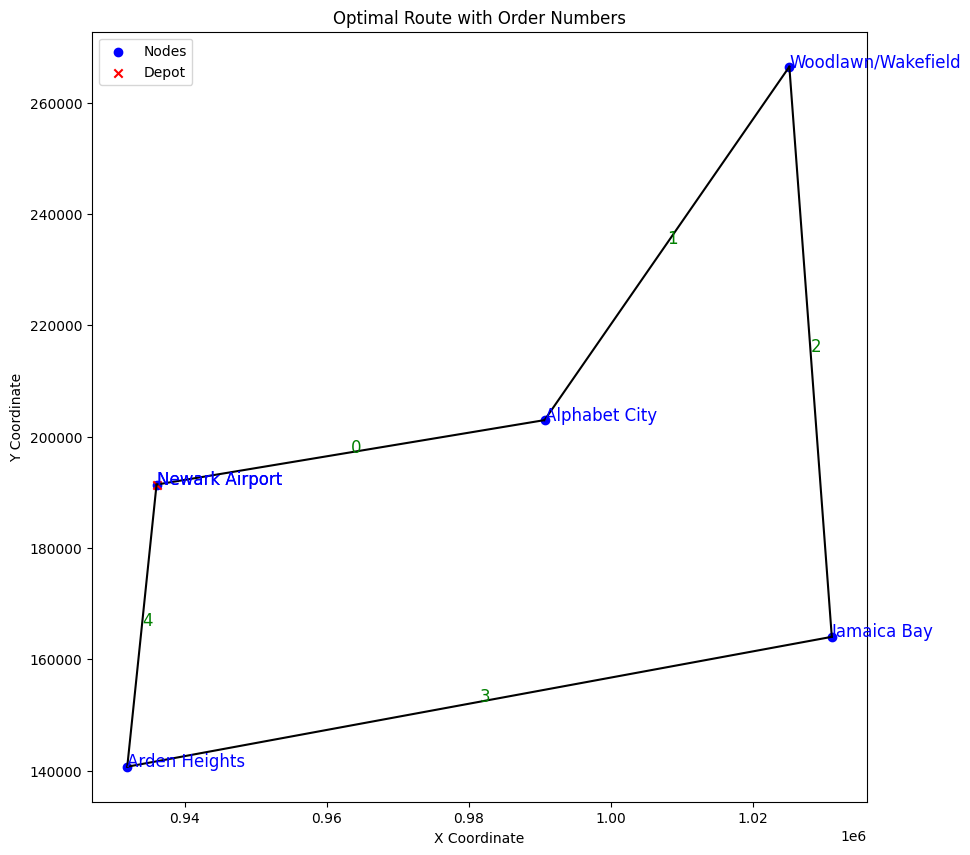

Optimal route:
depot -> Alphabet City -> Woodlawn/Wakefield -> Jamaica Bay -> Arden Heights -> depot
Total cost: 383493.636956


In [31]:
# Aplicar el algoritmo genético
route_labels, bf = genetic_algorithm_vrp(merged_data, zones1, capacity=100, popsize=500, iterations=100, threshold_distance=5000)

# Imprimir la solución
print('Optimal route:')
print(' -> '.join(route_labels))
print('Total cost: %f' % bf)

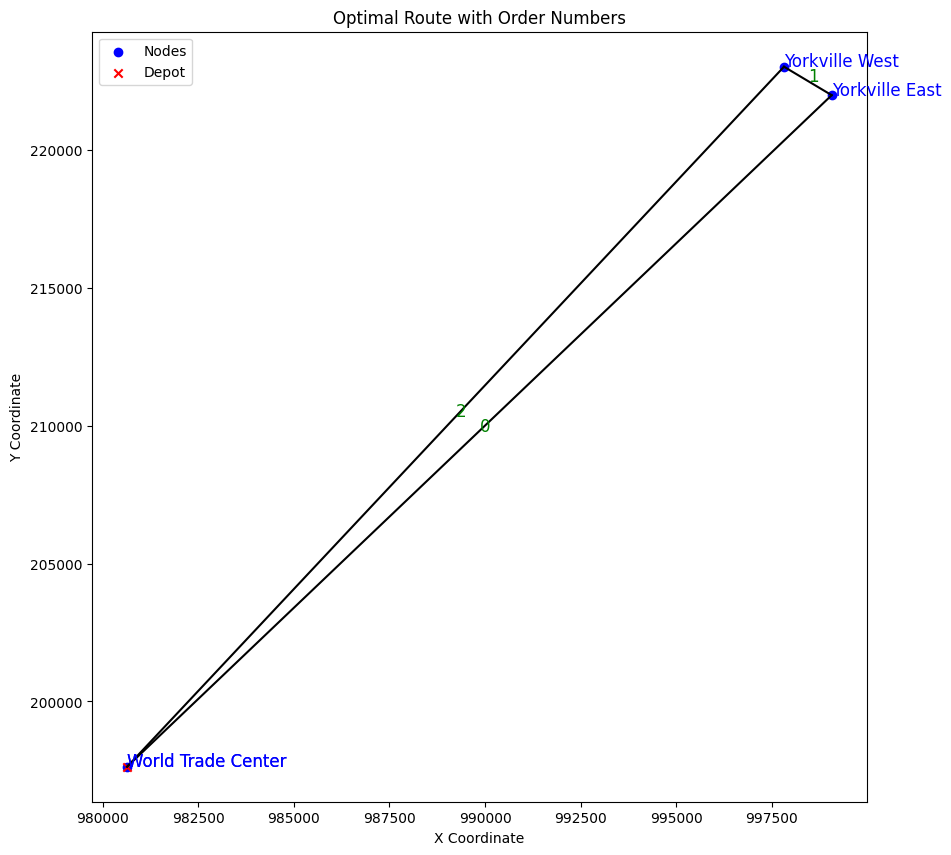

Optimal route:
depot -> Yorkville East -> Yorkville West -> depot
Total cost: 62784.504886


In [37]:
# Aplicar el algoritmo genético
route_labels, bf = genetic_algorithm_vrp(merged_data, zones2, capacity=100, popsize=500, iterations=100, threshold_distance=5000)

# Imprimir la solución
print('Optimal route:')
print(' -> '.join(route_labels))
print('Total cost: %f' % bf)

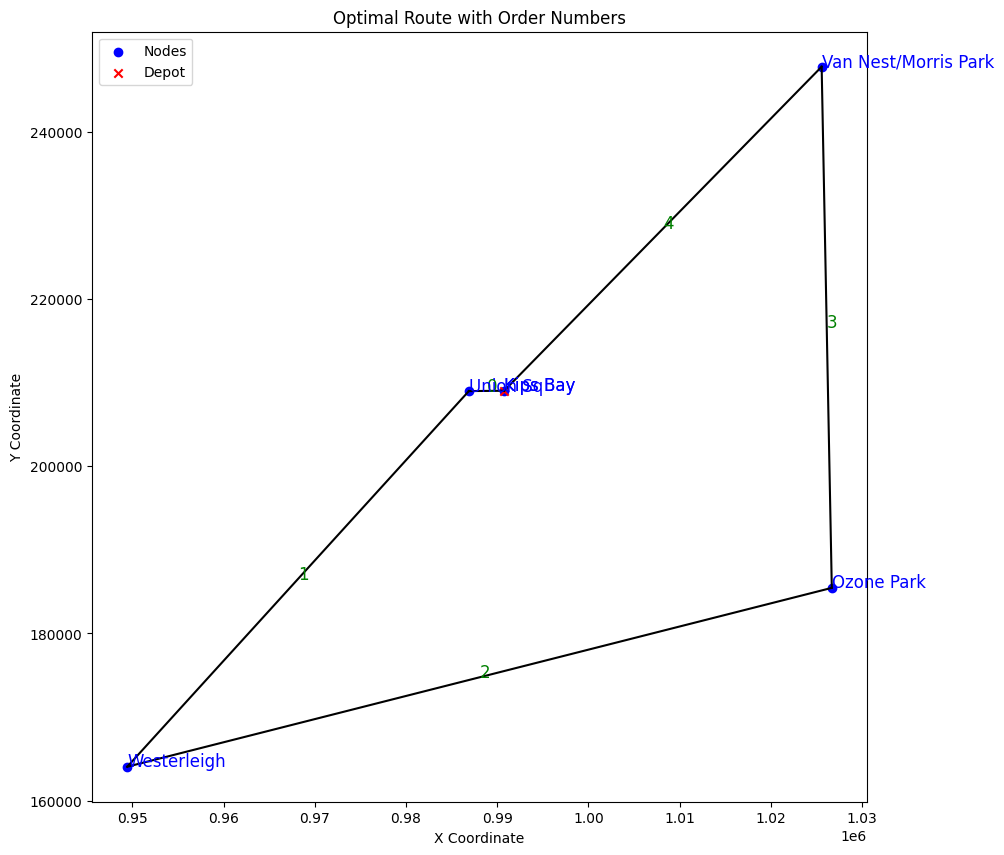

Optimal route:
depot -> Union Sq -> Westerleigh -> Ozone Park -> Van Nest/Morris Park -> depot
Total cost: 256996.885625


In [41]:
# Aplicar el algoritmo genético
route_labels, bf = genetic_algorithm_vrp(merged_data, random_zones, capacity=100, popsize=500, iterations=100, threshold_distance=5000)

# Imprimir la solución
print('Optimal route:')
print(' -> '.join(route_labels))
print('Total cost: %f' % bf)